In [1]:
%%capture
#additional data from https://github.com/nflverse/nfl_data_py

!jupyter nbextension enable --py widgetsnbextension

In [2]:
#immport necessary libraries and filter warnings
from IPython.display import Image
import gc
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import os
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, cohen_kappa_score, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from colorama import Fore, Style
from tqdm import tqdm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer, KNNImputer
from utility_db_25 import mark_columns, TrainML, calculate_and_plot_metrics, optuna_call, proc_external, build_transformer, get_final_features, build_catboost

In [3]:
!pip install pyarrow==17.0.0

## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment. 

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [4]:
#helper functions
#change all plays to same direction
def reverse_deg(deg):
    if deg < 180:
        return deg + 180
    if deg >= 18:
        return deg - 180

#merge all data specifically to pull the data for the team in possession during the play
def merge_clean_data(df_tracking, df_plays, df_player_plays):
    df_final=pd.merge(pd.merge(df_tracking, df_plays, left_on=[ 'gameId', 'playId','club'], right_on=[ 'gameId', 'playId', 'possessionTeam'], how='inner'), df_player_plays, left_on=[ 'gameId', 'playId', 'nflId'], right_on=[ 'gameId', 'playId', 'nflId'], how='left' )
    df_final=pd.merge(df_final, df_games, on='gameId', how='inner')
    del df_tracking
    gc.collect()
    df_final=pd.merge(df_final, df_players, on='nflId', how='inner')
    return df_final

In [5]:
nfl.import_pbp_data(years=[2022])

2022 done.
Downcasting floats.


,play_id,game_id,old_game_id_x,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,None,None,None,...,,,0,0,NaN,NaN,None,None,None,None
1,43.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036157;00-0035202;00-0037984;00-0029597;00...,00-0035537;00-0032134;00-0034419;00-0036500;00...,11,11,NaN,NaN,None,None,None,None
2,68.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,NaN,NaN,None,None,None,None
3,89.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0032234;00-0036979;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,0.56,3.070,True,ANGLE,ZONE_COVERAGE,COVER_2
4,115.0,2022_01_BAL_NYJ,2022091107,NYJ,BAL,REG,1,NYJ,home,BAL,...,00-0036924;00-0032466;00-0036979;00-0032234;00...,00-0033294;00-0026190;00-0032574;00-0028278;00...,11,11,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49429,4035.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,None,None,None,...,,,0,0,NaN,NaN,None,None,None,None
49430,4024.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,KC,away,PHI,...,00-0030615;00-0034752;00-0036230;00-0036623;00...,00-0036813;00-0037073;00-0036917;00-0037615;00...,11,11,NaN,NaN,None,None,None,None
49431,4050.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,00-0035157;00-0037198;00-0037819;00-0038043;00...,00-0036813;00-0036919;00-0033251;00-0036917;00...,11,11,NaN,NaN,None,None,None,None
49432,4072.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,00-0036271;00-0034351;00-0032954;00-0036919;00...,00-0036374;00-0035157;00-0035625;00-0037819;00...,11,11,NaN,6.073,False,None,ZONE_COVERAGE,PREVENT


In [6]:
#read games, players, plays, and player_plays data
file='data/'
df_games=pd.read_csv(file+'games.csv')
df_players=pd.read_csv(file+'players.csv')
df_players.loc[df_players['nflId'] ==45244, 'position'] = 'TE' #update data for Taysom Hill
df_plays=pd.read_csv(file+'plays.csv')
#pull stadium data for current season games
df_stadium=nfl.import_schedules([2022])
df_stadium=df_stadium[df_stadium['week']<=9][[ 'old_game_id','roof', 'surface']]

#get game weather
df_games_weather=nfl.import_pbp_data(years=[2022])[['old_game_id_x',  'weather' ]].drop_duplicates()
df_games_weather['gameId']=df_games_weather['old_game_id_x'].astype(int)
df_games_weather['Rain']=np.where(df_games_weather['weather'].str.contains('Rain'), 1, 0)
df_games_weather[['temp', 'humidity', 'wind']]=df_games_weather['weather'].str.split(',', expand=True).iloc[:, :3]
df_games_weather['temp'] = df_games_weather['temp'].str.split(':', expand=True).iloc[:, 1:2]
df_games_weather['temp']=df_games_weather['temp'].str.extract('(\d+)')
df_games_weather['humidity'] = df_games_weather['humidity'].str.extract('(\d+)')
df_games_weather['wind'] = df_games_weather['wind'].str.extract('(\d+)')

df_games=pd.merge(df_games, df_stadium,left_on='gameId', right_on='old_game_id', how='left')
df_games=pd.merge(df_games, df_games_weather,on='gameId', how='left')



2022 done.
Downcasting floats.


In [7]:
#pull previous year pass rush data by team
df_player_plays=pd.read_csv(file+'player_play.csv')
df_rush2021=nfl.import_ngs_data(stat_type='rushing', years=[2021])[['team_abbr', 'rush_attempts']].groupby('team_abbr').sum().reset_index()
df_pass2021=nfl.import_ngs_data(stat_type='passing', years=[2021])[['team_abbr', 'attempts']].groupby('team_abbr').sum().reset_index()
df_pass_rush2021=pd.merge(df_rush2021, df_pass2021, on='team_abbr', how='outer')
df_pass_rush2021['pass_rush_ratio']=np.round((df_pass_rush2021['attempts']/df_pass_rush2021['rush_attempts']), 2)
df_pass_rush2021.drop(columns=['rush_attempts', 'attempts'], inplace=True)
df_player_plays=pd.merge(df_player_plays, df_pass_rush2021, left_on='teamAbbr', right_on='team_abbr', how='outer')


In [8]:
#features for plays df 
df_plays['time_remaining'] = df_plays['quarter'].map({1: 45, 2: 30, 3: 15, 4: 0}) + \
                               df_plays['gameClock'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
df_plays['score_differential'] = df_plays['preSnapHomeScore'] - df_plays['preSnapVisitorScore']

In [9]:
exclude_events=['huddle_break_offense'] #exclude frame with huddle break event
tracking_files=[]
for i in range(1,9):  #read some or all of weeks tracking data
    file='data/tracking_week_'+str(i)+'.csv'
    df_tracking=pd.read_csv(file)
    df_tracking=df_tracking[ (df_tracking['frameType']=='BEFORE_SNAP')& (~df_tracking['event'].isin(exclude_events))]
    df_tracking['gameplayId']=df_tracking['gameId'].astype(str)+'_'+df_tracking['playId'].astype(str)
    playstodrop=df_tracking[df_tracking['event'].isin(['huddle_start_offense', 'timeout_away'])][['gameplayId']].drop_duplicates() #plays with huddle start or timeout we should drop
    df_tracking = df_tracking[~df_tracking['gameplayId'].isin(playstodrop['gameplayId'])]
    
    #nromalize o, dir, x, y
    df_tracking['o_standard']=np.where(df_tracking["playDirection"] == "left",df_tracking['o'].apply(reverse_deg), df_tracking['o'])
    df_tracking['dir_standard']=np.where(df_tracking["playDirection"] == "left",df_tracking['dir'].apply(reverse_deg), df_tracking['dir'])
    df_tracking["x_standard"] = np.where(df_tracking["playDirection"] == "left", df_tracking["x"].apply(lambda x: 120 - x), df_tracking["x"])
    df_tracking["y_standard"] =np.where(df_tracking["playDirection"] == "left",  df_tracking["y"].apply(lambda y: 160/3 - y), df_tracking["y"])
   
    df_tracking=df_tracking[['gameId', 'playId', 'nflId','club' ,'o_standard', 'dir_standard', 'x_standard', 'y_standard', 's', 'a', 'dis']].groupby(['gameId', 'playId', 'nflId','club']).agg({'s':[ 'max',],'a':[ 'max'], 
    'o_standard':['mean', 'std'],'dis':['sum'],'dir_standard':['mean', 'std'], 'x_standard':['mean', 'std'], 'y_standard':['mean', 'std']}).reset_index()
    df_tracking.columns=df_tracking.columns.map('|'.join).str.strip('|')
    #filter on before snap and exclude the specific events
    #merge all data
    merged=merge_clean_data(df_tracking, df_plays, df_player_plays)
    del df_tracking
    #drop unnecessary columns to save memory
    merged.drop(columns=[   'playDescription',
          'possessionTeam', 'defensiveTeam',
           'yardlineSide', 'yardlineNumber', 'gameClock', 
             'expectedPoints',
          'playClockAtSnap',
          'passLength', 'targetX', 'targetY', 'playAction',
           'dropbackType', 'dropbackDistance', 'passLocationType',
           'timeToThrow', 'timeInTackleBox', 'timeToSack', 'passTippedAtLine',
           'unblockedPressure', 'qbSpike', 'qbKneel', 'qbSneak',
           'rushLocationType', 'penaltyYards_x', 'prePenaltyYardsGained',
           'yardsGained', 'homeTeamWinProbabilityAdded',
           'visitorTeamWinProbilityAdded', 'expectedPointsAdded',
            'pff_runConceptPrimary', 'pff_runConceptSecondary',
           'pff_runPassOption', 'pff_passCoverage',  'teamAbbr',
           'hadRushAttempt', 'rushingYards', 'hadDropback', 'passingYards',
           'sackYardsAsOffense', 'hadPassReception', 'receivingYards',
           'wasTargettedReceiver', 'yardageGainedAfterTheCatch', 'fumbles',
           'fumbleLost', 'fumbleOutOfBounds', 'assistedTackle',
           'forcedFumbleAsDefense', 'halfSackYardsAsDefense', 'passDefensed',
           'quarterbackHit', 'sackYardsAsDefense', 'safetyAsDefense',
           'soloTackle', 'tackleAssist', 'tackleForALoss',
           'tackleForALossYardage', 'hadInterception', 'interceptionYards',
           'fumbleRecoveries', 'fumbleRecoveryYards', 'penaltyYards_y',
           'penaltyNames', 'wasInitialPassRusher', 'causedPressure',
           'timeToPressureAsPassRusher', 'getOffTimeAsPassRusher',
           'inMotionAtBallSnap', 
           'wasRunningRoute', 'routeRan', 'blockedPlayerNFLId1','pff_manZone',
           'blockedPlayerNFLId2', 'blockedPlayerNFLId3',
           'pressureAllowedAsBlocker', 'timeToPressureAllowedAsBlocker',
           'pff_defensiveCoverageAssignment',
           'pff_primaryDefensiveCoverageMatchupNflId',
           'pff_secondaryDefensiveCoverageMatchupNflId', 'height', 'weight','season', 'team_abbr',  'season', 'week',
       'gameDate', 'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr',
       'homeFinalScore', 'visitorFinalScore', 'old_game_id', 'old_game_id_x', 'weather',
           'birthDate', 'collegeName'], inplace=True)
        #get the count of players in each position for each play and take the max
    merged['pos_count']=(merged[['gameId', 'playId', 'position', 'nflId']].drop_duplicates().sort_values(by=['gameId', 'playId', 'position']).groupby(by=['gameId', 'playId', 'position']).cumcount()+1)
    merged['pos_count'].fillna(99, inplace=True)
    merged['pos_count']=merged['pos_count'].astype(int)
    #create a position_pivot column so that each player has a unique value during the play
    merged['position_pivot']=merged['position']+'_'+merged['pos_count'].astype(str)
    tracking_files.append(merged)
    del merged
    gc.collect()
merged=pd.concat(tracking_files)

In [10]:
#create 'pass' variable for pass attempt play based on isDropback=True

merged['pass']=np.where(merged['isDropback']==True, 1, 0)


In [11]:
merged_pivot=merged.pivot(index=['gameId', 'playId','quarter', 'down', 'yardsToGo', 'score_differential', 'time_remaining', 'playNullifiedByPenalty','preSnapHomeTeamWinProbability', 'pass_rush_ratio', 'roof', 'surface', 'Rain', 'temp', 'humidity', 'wind',
           'preSnapVisitorTeamWinProbability',
           'absoluteYardlineNumber', 'offenseFormation', 'receiverAlignment',
           'pass'], columns=['position_pivot'], values=['s|max', 'a|max',
       'o_standard|mean', 'o_standard|std', 'dis|sum', 'dir_standard|mean',
       'dir_standard|std', 'x_standard|mean', 'x_standard|std',
       'y_standard|mean', 'y_standard|std', 'shiftSinceLineset', 'motionSinceLineset']).fillna(0).reset_index() 
merged_pivot.columns =merged_pivot.columns.map('|'.join).str.strip('|')
merged_pivot.replace({False:0, True:1}, inplace=True)

In [12]:
del merged
gc.collect()

10

In [13]:
#merged_pivot=pd.get_dummies(merged_pivot, columns=['offenseFormation','receiverAlignment','pff_manZone', 'roof', 'surface'],dtype=int)
# Define categorical and numerical columns

merged_pivot = pd.get_dummies(merged_pivot, columns=['offenseFormation','receiverAlignment', 'roof', 'surface'])



In [14]:
for col in merged_pivot.columns: 
    if round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2)>75:
        merged_pivot.drop(columns=col, inplace=True)
    elif round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2)>0:
        print(col,round((merged_pivot[col].isna().sum() /len(merged_pivot)*100), 2), '% missing')
    else: 
        print(col)

gameId
playId
quarter
down
yardsToGo
score_differential
time_remaining 0.81 % missing
playNullifiedByPenalty
preSnapHomeTeamWinProbability
pass_rush_ratio 2.84 % missing
Rain
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
preSnapVisitorTeamWinProbability
absoluteYardlineNumber
pass
s|max|C_1
s|max|C_2
s|max|DT_1
s|max|FB_1
s|max|FS_1
s|max|G_1
s|max|G_2
s|max|G_3
s|max|G_4
s|max|ILB_1
s|max|OLB_1
s|max|QB_1
s|max|QB_2
s|max|RB_1
s|max|RB_2
s|max|RB_3
s|max|TE_1
s|max|TE_2
s|max|TE_3
s|max|TE_4
s|max|T_1
s|max|T_2
s|max|T_3
s|max|T_4
s|max|WR_1
s|max|WR_2
s|max|WR_3
s|max|WR_4
s|max|WR_5
a|max|C_1
a|max|C_2
a|max|DT_1
a|max|FB_1
a|max|FS_1
a|max|G_1
a|max|G_2
a|max|G_3
a|max|G_4
a|max|ILB_1
a|max|OLB_1
a|max|QB_1
a|max|QB_2
a|max|RB_1
a|max|RB_2
a|max|RB_3
a|max|TE_1
a|max|TE_2
a|max|TE_3
a|max|TE_4
a|max|T_1
a|max|T_2
a|max|T_3
a|max|T_4
a|max|WR_1
a|max|WR_2
a|max|WR_3
a|max|WR_4
a|max|WR_5
o_standard|mean|C_1
o_standard|mean|C_2
o_standard|mean|DT_1
o_standard|mean|F

### Add pass-rate, ftn, coverage data

In [15]:
xp_df = pd.read_csv('created-data-db-25/team_xpass_ratios.csv').drop(columns='Unnamed: 0')
pr_df = pd.read_csv('created-data-db-25/team_pass_rates.csv').drop(columns='Unnamed: 0')

In [16]:
cf_df = pd.read_csv('created-data-db-25/coverages_faced.csv').drop(columns='Unnamed: 0')
cu_df = pd.read_csv('created-data-db-25/coverages_used.csv').drop(columns='Unnamed: 0')

In [17]:
merged_pivot = proc_external(xp_df, pr_df, cf_df, cu_df, df_games, df_plays, merged_pivot)

2022 done.
Downcasting floats.
Downcasting floats.


In [18]:
merged_pivot.sample(3)

,gameId,playId,quarter,down,yardsToGo,score_differential,time_remaining,playNullifiedByPenalty,preSnapHomeTeamWinProbability,pass_rush_ratio,...,Zone_off,cover_3_def,cover_6_def,cover_1_def,Quarters_def,Cover-2_def,Cover-0_def,Man_def,Other_def,Zone_def
14259,2022103011,1647,2,2,17,0,33.966667,N,0.607265,1.02,...,240.0,106.0,19.0,147.0,47.0,9.0,27.0,183.0,13.0,181.0
4533,2022092505,1677,2,1,10,-4,30.500000,N,0.385152,1.73,...,69.0,48.0,13.0,23.0,23.0,17.0,4.0,27.0,9.0,101.0
4718,2022092506,3745,4,2,6,-15,10.616667,N,0.044449,3.00,...,102.0,39.0,8.0,31.0,11.0,10.0,7.0,39.0,7.0,68.0


### Call helpers to get final features (by correlation, etc.)

In [19]:
final_features = get_final_features(merged_pivot,threshold=.8,trim_rows=8)

In [20]:
numeric_columns,cat_columns = mark_columns(merged_pivot,final_features)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

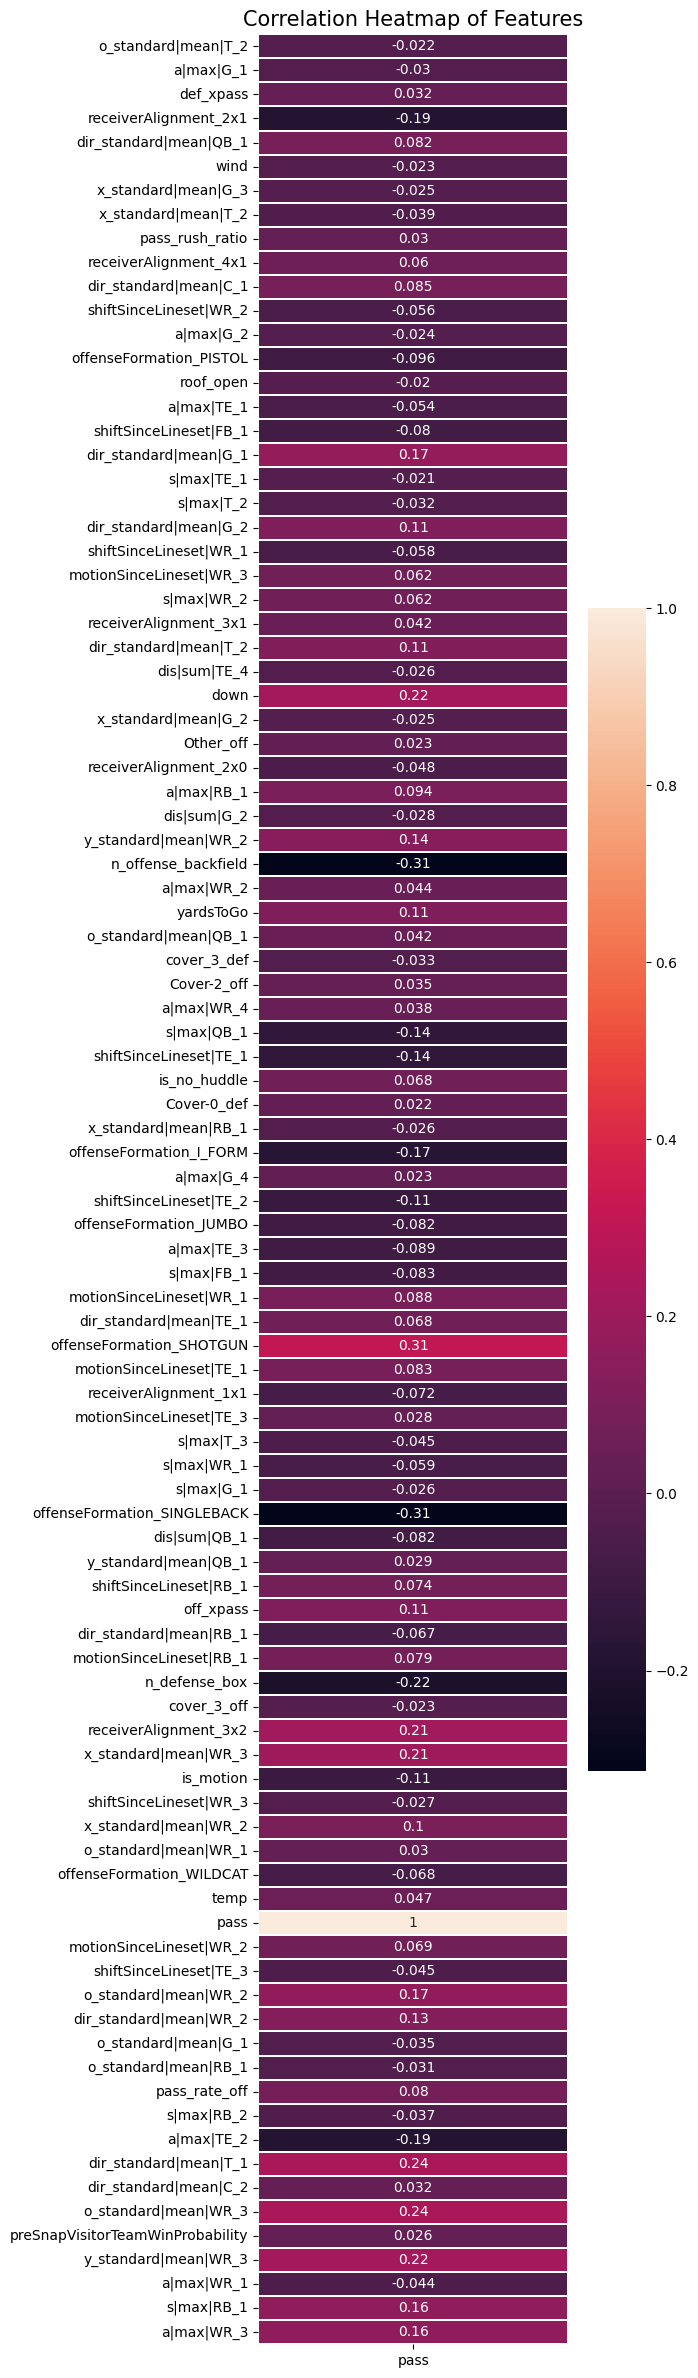

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,30))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(merged_pivot[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [22]:
# Create an imputer object with mean strategy
from sklearn.compose import ColumnTransformer


# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = build_transformer(imputer,numeric_columns)

In [23]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=merged_pivot[final_features].drop(columns='pass')

y=merged_pivot['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 13.28it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


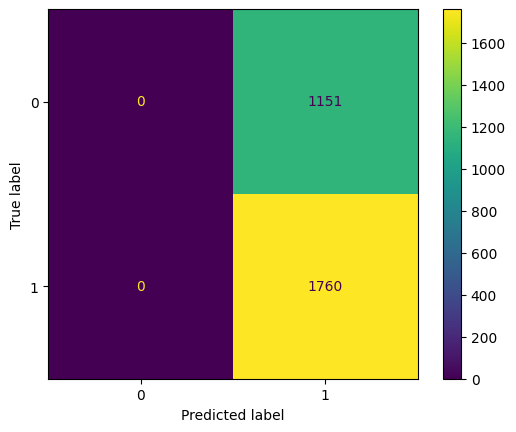

In [24]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y, n_splits, SEED)

Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

Mean Train AUC --> 0.8990
Mean Validation AUC ---> 0.7867
Mean Train Accuracy --> 0.9043
Mean Validation Accuracy ---> 0.7977


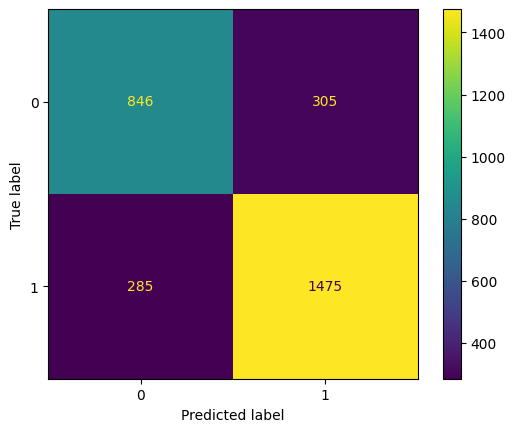

In [25]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
TrainML(pipeline,X, y, n_splits, SEED)

Training Folds: 100%|██████████| 5/5 [00:31<00:00,  6.26s/it]

Mean Train AUC --> 0.9056
Mean Validation AUC ---> 0.7882
Mean Train Accuracy --> 0.9119
Mean Validation Accuracy ---> 0.8002


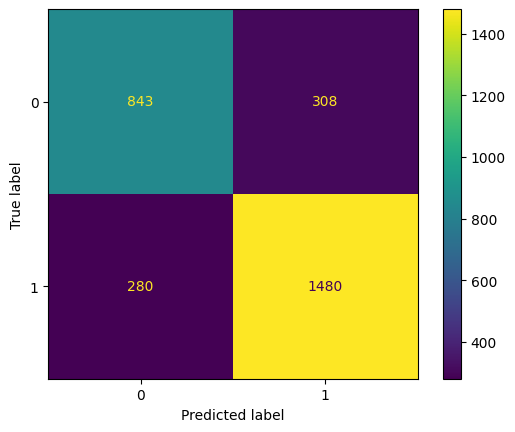

In [26]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  verbose=False))], verbose = True)
TrainML(pipeline,X, y, n_splits, SEED)

In [27]:
X['yardsToGo']=X['yardsToGo'].astype(float)

In [28]:
final_features.remove('pass')

In [29]:
[x for x in numeric_columns if 'FB' in x]

['s|max|FB_1']

In [30]:
#X_transform.isna().sum()

In [31]:
X[numeric_columns].isna().sum().sum()

18012

In [32]:
X.head(1)

,o_standard|mean|T_2,a|max|G_1,def_xpass,receiverAlignment_2x1,dir_standard|mean|QB_1,wind,x_standard|mean|G_3,x_standard|mean|T_2,pass_rush_ratio,receiverAlignment_4x1,...,s|max|RB_2,a|max|TE_2,dir_standard|mean|T_1,dir_standard|mean|C_2,o_standard|mean|WR_3,preSnapVisitorTeamWinProbability,y_standard|mean|WR_3,a|max|WR_1,s|max|RB_1,a|max|WR_3
0,77.462292,1.33,NaN,False,186.141181,8.0,0.0,33.551597,2.72,False,...,0.0,0.0,80.374028,157.848472,82.923194,0.586653,41.523611,2.78,1.07,2.71


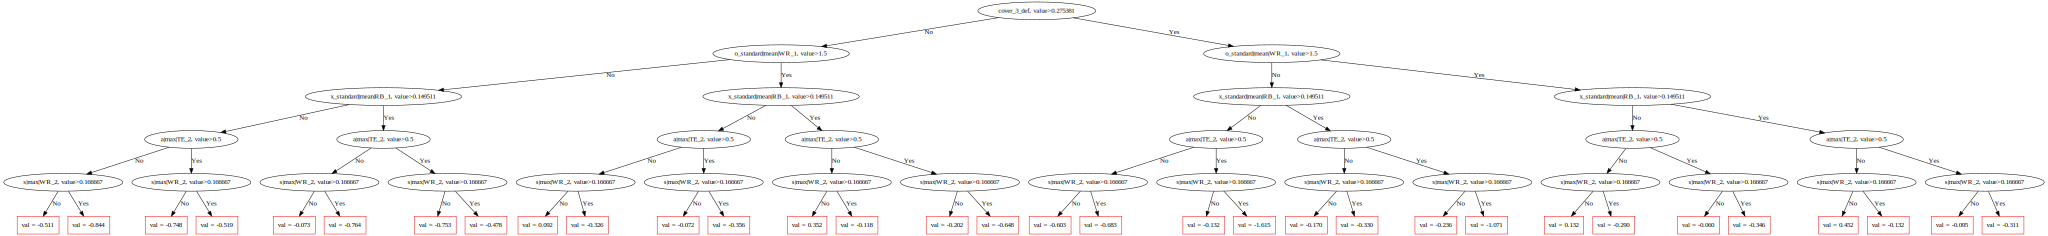

In [33]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline

# For explicitly displaying widgets
from IPython.display import display

model,pool,cat_features_index,X_transform = build_catboost(final_features, merged_pivot, imputer)

model.plot_tree(
        tree_idx=1,
        pool=pool
    )

In [35]:
cat_features_index

array([ 3,  9, 11, 13, 14, 16, 21, 22, 24, 27, 30, 36, 42, 43, 46, 48, 49,
       52, 54, 55, 56, 57, 61, 64, 67, 70, 72, 73, 76, 78, 79])

In [67]:
import shap
model = CatBoostClassifier( 
    verbose=False).fit(pool)
shap_values = model.get_feature_importance(Pool(X_transform, label=y, cat_features=cat_features_index),type="ShapValues")
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X, plot_type="bar")

In [64]:
shap.summary_plot(shap_values, X, plot_type="bar")


In [38]:
importances =model.get_feature_importance(type='PredictionValuesChange')
feature_importances=pd.Series(importances, index=X.columns).sort_values()
feature_importance_df=pd.DataFrame(feature_importances, columns=[ 'importance']).sort_values('importance', ascending=False)
selected_features=list(feature_importance_df.head(len(final_features)).T.columns)
top_30_features=list(feature_importance_df.head(30).T.columns)
top_30_features.append('pass')

In [39]:
list(top_30_features)

['o_standard|mean|WR_3',
 'shiftSinceLineset|WR_3',
 'o_standard|mean|G_1',
 'o_standard|mean|WR_1',
 's|max|WR_2',
 's|max|WR_1',
 'Cover-2_off',
 'pass_rush_ratio',
 'o_standard|mean|RB_1',
 'Cover-0_def',
 'dir_standard|mean|WR_2',
 'dis|sum|QB_1',
 'o_standard|mean|QB_1',
 'a|max|G_4',
 'x_standard|mean|T_2',
 'def_xpass',
 'a|max|TE_3',
 'a|max|TE_1',
 'dir_standard|mean|TE_1',
 'a|max|WR_2',
 'a|max|TE_2',
 'dir_standard|mean|T_2',
 's|max|QB_1',
 'a|max|G_2',
 's|max|RB_1',
 'a|max|RB_1',
 'Other_off',
 'dis|sum|TE_4',
 'y_standard|mean|QB_1',
 'offenseFormation_WILDCAT',
 'pass']

In [40]:
%%capture
!pip install pandas numpy matplotlib seaborn holoviews
!pip install autoviz
from autoviz.AutoViz_Class import AutoViz_Class

In [41]:
'''
%matplotlib inline

AV = AutoViz_Class()

AV.AutoViz("", dfte=merged_pivot[top_30_features].corr(), depVar='pass', verbose=0)
'''

'\n%matplotlib inline\n\nAV = AutoViz_Class()\n\nAV.AutoViz("", dfte=merged_pivot[top_30_features].corr(), depVar=\'pass\', verbose=0)\n'

In [42]:
final_cat_columns=[]
for c in cat_columns:
    if c in selected_features:
        final_cat_columns.append(c)

In [43]:
final_numeric_columns=[]
for i in selected_features:
       if merged_pivot[i].dtype!='O' and i!='pass' and 'shiftSinceLineset' not in i and 'motionSinceLineset' not in i and  'offenseFormation' not in i and'receiverAlignment'not in i and 'Cover'not in i and 'roof' not in i and 'surface' not in i and 'is_no_huddle' not in i and 'is_no_motion' not in i:
            final_numeric_columns.append(i)
    

In [44]:
# Create a transformer
transformer = build_transformer(imputer,final_numeric_columns)

### Note: deprecate 'objective'? (not using the tune below)

In [45]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
X=merged_pivot[selected_features]

y=merged_pivot['pass']
# Define the helper function so that it can be reused

cat_params = optuna_call(transformer,X,y,SKF,n_trials=5)

[I 2024-10-24 18:17:38,015] A new study created in memory with name: no-name-fe18ca2f-7171-4346-a175-f43179b15035


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-10-24 18:17:44,147] Trial 0 finished with value: 0.7895024933843209 and parameters: {'learning_rate': 0.045595014869780265, 'depth': 4, 'subsample': 0.5385874310469778, 'colsample_bylevel': 0.27656455561275567, 'iterations': 406}. Best is trial 0 with value: 0.7895024933843209.
[I 2024-10-24 18:18:13,497] Trial 1 finished with value: 0.7969219161120569 and parameters: {'learning_rate': 0.07762173794986162, 'depth': 9, 'subsample': 0.6445815326765998, 'colsample_bylevel': 0.4645367498035873, 'iterations': 287}. Best is trial 1 with value: 0.7969219161120569.
[I 2024-10-24 18:18:21,048] Trial 2 finished with value: 0.7829074116368002 and parameters: {'learning_rate': 0.02588305403090547, 'depth': 4, 'subsample': 0.8650477192013362, 'colsample_bylevel': 0.46992540958315016, 'iterations': 495}. Best is trial 1 with value: 0.7969219161120569.
[I 2024-10-24 18:18:31,980] Trial 3 finished with value: 0.7785108870861189 and parameters: {'learning_rate': 0.022412103829905126, 'depth': 7

In [46]:
#cat_params={'learning_rate': 0.09266434349818461, 'depth': 8, 'subsample': 0.9490011978490482, 'colsample_bylevel': 0.8112961715549822, 'iterations': 469}

In [47]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  **cat_params, verbose=False))], verbose = True)
TrainML(pipeline,X, y, n_splits, SEED)

Training Folds: 100%|██████████| 5/5 [00:28<00:00,  5.76s/it]

Mean Train AUC --> 0.9784
Mean Validation AUC ---> 0.7846
Mean Train Accuracy --> 0.9810
Mean Validation Accuracy ---> 0.7969


In [48]:
uniqueplays=len(merged_pivot)
playswithpasses=len(merged_pivot[merged_pivot['pass']==1])

print('Unique plays:' , uniqueplays)
print('Unique plays with passes:' ,playswithpasses )
print('% Plays with Pass Attempts: ', round((playswithpasses/uniqueplays)*100, 1), '%')

Unique plays: 14556
Unique plays with passes: 8801
% Plays with Pass Attempts:  60.5 %


In [49]:
# Create a transformer
transformer = build_transformer(imputer,numeric_columns=final_numeric_columns)

In [50]:
X=merged_pivot[selected_features]

y=merged_pivot['pass']



X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,stratify=y_temp,  test_size=0.5, random_state=42)


In [51]:
tf.random.set_seed(42)
# Define the MLP model
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the epoch with the best value of the monitored quantity
)

imputer_k = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

scaler=MinMaxScaler()
transformer.fit(X_train)
imputer_k.fit(X_train)
X_train_scaled = imputer_k.transform(transformer.transform(X_train))
X_val_scaled =imputer_k.transform(transformer.transform(X_val))
X_test_scaled = imputer_k.transform(transformer.transform(X_test))

model = Sequential()

model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(.005))
model.add(Dense(8, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(.005))
model.add(Dense(1, activation='sigmoid'))
initial_weights = model.get_weights()
optimizer = keras.optimizers.Adam(.0004)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [52]:
accuracy1_mlp, f1_1_mlp, precision1_mlp, recall1_mlp, roc = calculate_and_plot_metrics(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, "Pass Probability Keras MLP",model, early_stopping)


print(f"Accuracy: {accuracy1_mlp:.4f}\nF1 Score: {f1_1_mlp:.4f}\nPrecision: {precision1_mlp:.4f}\nRecall: {recall1_mlp:.4f}\nROC AUC: {roc:.4f}\n")

Epoch 1/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step - accuracy: 0.6219 - loss: 0.6487 - val_accuracy: 0.7215 - val_loss: 0.5587
Epoch 2/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.7313 - loss: 0.5505 - val_accuracy: 0.7568 - val_loss: 0.5145
Epoch 3/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7457 - loss: 0.5201 - val_accuracy: 0.7636 - val_loss: 0.4998
Epoch 4/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.7531 - loss: 0.5034 - val_accuracy: 0.7595 - val_loss: 0.4920
Epoch 5/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.7573 - loss: 0.4923 - val_accuracy: 0.7691 - val_loss: 0.4842
Epoch 6/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.7662 - loss: 0.4828 - val_accuracy: 0.7710 - val_loss: 0.4815
Epoch 7/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.7727 - loss: 0.4757 - val_accuracy: 0.7719 - val_loss: 0.4791
Epoch 8/250
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7756 - loss: 0.4

In [53]:
from tensorflow.keras.utils import plot_model
 #Plot the model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.
